# This notebook is used to inspect an input file
e.g. to figure out the number of primary neutral pions, etc.

In [1]:
import sys
sys.path.append("../../lartpc_mlreco3d")                                                          # JupyterLab
sys.path.append("../../pi0_reco")                                                                 # JupyterLab

In [2]:
io_cfg = '''
iotool:
  batch_size: 1
  shuffle: False
  num_workers: 4
  collate_fn: CollateSparse
  dataset:
    name: LArCVDataset
    data_keys:
      #- ../../data/others/test.root
      - ../../data/pi0/pi0_dunend_v1_p00.root
      #- ../../data/pi0/pi0_dunend_v2_p00.root
    limit_num_files: 1
    schema:
      input_data:
        - parse_sparse3d_scn
        - sparse3d_pcluster
      segment_label:
        - parse_sparse3d_scn
        - sparse3d_pcluster_semantics
      semantics:
        - parse_sparse3d_scn
        - sparse3d_pcluster_semantics
      dbscan_label:
        - parse_cluster3d_clean_full
        - cluster3d_pcluster
        - particle_corrected
        - sparse3d_pcluster_semantics
      particles_label:
        - parse_particle_points
        - sparse3d_pcluster
        - particle_corrected
      particles:
        - parse_particle_asis
        - particle_corrected
        - cluster3d_pcluster
      cluster_label:
        - parse_cluster3d_full
        - cluster3d_pcluster
        - particle_corrected
'''

# Convert the string to a dictionary
#import yaml
#cfg = yaml.load(cfg,Loader=yaml.Loader)

# Pre-process configuration
#from mlreco.main_funcs import process_config
#process_config(cfg)

In [3]:
from mlreco.main_funcs import prepare, apply_event_filter
from mlreco.utils.gnn.evaluation import node_assignment, node_assignment_bipartite, edge_assignment_score, clustering_metrics, node_assignment_score

In [4]:
# Configuration of the reconstruction chain
chain_cfg = '''
name: pi0_chain_test     # Name of the chain to name the output files
verbose: false           # true, false
analyse: true            # true, false
mlreco: 
  cfg_path: ../../config_files/network_configs/fullChain_grappa_20210128.cfg # IO and/or network configuration
  #model_path: '/gpfs/slac/staas/fs1/g/neutrino/drielsma/pi0/train/weights/shower_only/snapshot-112999.ckpt'
  model_path: '../../weights/snapshot-117999.ckpt'
  batch_size: 1          # Number of event to process at each iteration
  data_keys:             # Test file
     #- ../../data/others/test.root
modules:
  segment: 
    method: uresnet      # label, uresnet
  deghost:
    method: none         # label, uresnet, none
  charge2e:
    method: none         # label, constant, average, none
    cst: 0.0082          # energy response constant (0.0082 for mask, 0.0052 for uresnet)
    average: 0.877       # energy response average (1.3693 for mask, 0.877 for uresnet)
  shower_fragment:  
    method: gnn          # label, dbscan, gnn
    eps: 1.999
    min_samples: 1
  shower_primary:
    method: gnn          # label, gnn
  shower_start:     
    method: ppn          # label, ppn, curv
  shower_direction: 
    method: geo          # label, geo
    mode: cent
    max_distance: 5
    optimize: true
    normalize: true
    weighted: false
  shower_cluster:
    method: gnn          # label, cone, gnn
    predict_mode: score
    scale_embedding: 1.0
    IP: 15
    Distance: 300
  shower_energy: 
    method: pixel_sum    # label, pixel_sum
    fudge: 1.205
  shower_id:
    method: edep         # label, edep, gnn
  shower_match:
    method: ppn          # label, proximity, ppn, gnn
    verbose: false       # true, false
    refit_dir: true      # true, false
    redit_cone: true     # true, false
  fiducial:
    method: none         # none, edge_dist
    max_distance: 5
fiducialize:               14                          # Number of pixels to be removed from edge of LAr volume (pixel pitch: 3mm)
PPN_score_thresh:          [0.5, 0.5, 0.5, 0.5, 0.5]   # For PPN predictions to be classified as shower, track, michel, delta or LEScatter, respectively
analyse_true:              True                        # Whether the analyser module for (simulated) true data is used or not
analyse_reco:              True                        # Whether the analyser module for (simulated or real) reco data is used or not
'''

import yaml
chain_cfg = yaml.load(chain_cfg,Loader=yaml.Loader)

In [5]:
# Progress bar
from IPython.display import HTML, display
def progress(count, total, unit, message=''):
    return HTML("""
        <progress 
            value='{count}'
            max='{total}',
            style='width: 30%'
        >
            {count}
        </progress> {count}/{total} {unit} ({frac}%) ... {message}
    """.format(count=count, total=total, unit=unit, frac=int(float(count)/float(total)*100.),message=message))

In [6]:
# Some imports
import numpy as np
from larcv import larcv
from numpy import linalg

Welcome to JupyROOT 6.22/02


In [7]:
# Initialize the chain
from pi0.chain import Pi0Chain
chain = Pi0Chain(io_cfg, chain_cfg)

Initialized Pi0 mass chain, log path: masses_fiducialized_14px.csv

Config processed at: Linux tur001 3.10.0-1127.13.1.el7.x86_64 #1 SMP Tue Jun 23 15:46:38 UTC 2020 x86_64 x86_64 x86_64 GNU/Linux

$CUDA_VISIBLE_DEVICES=""

{   'iotool': {   'batch_size': 1,
                  'collate_fn': 'CollateSparse',
                  'dataset': {   'data_keys': [   '../../data/pi0/pi0_dunend_v1_p00.root'],
                                 'limit_num_files': 1,
                                 'name': 'LArCVDataset',
                                 'schema': {   'cluster_label': [   'parse_cluster3d_full',
                                                                    'cluster3d_pcluster',
                                                                    'particle_corrected'],
                                               'dbscan_label': [   'parse_cluster3d_clean_full',
                                                                   'cluster3d_pcluster',
                             

In [8]:
#print(chain.data_set.dataset.data_keys())

In [9]:
# Loop over dataset
data_size  = 2000# len(chain.hs.data_io)

n_true_pi0         = 0
n_true_pi0_list    = []
n_reco_pi0         = 0
n_reco_pi0_list    = []
n_primary_photons  = 0
n_primary_e_minus  = 0
n_primary_e_plus   = 0
n_primary_n        = 0
n_primary_p        = 0
n_primary_mu_minus = 0
n_primary_mu_plus  = 0
n_primary_pi_minus = 0
n_primary_pi_plus  = 0
#n_else             = 0

out = display(progress(0,data_size,'images'),display_id=True)
for event in range(data_size):
    chain.run_loop()
    assert chain.true_info['ev_id'] == chain.event['index']
    
    # Count primary particles and their types:
    n_true_pi0         += chain.true_info['n_pi0']
    n_true_pi0_list.append(chain.true_info['n_pi0'])
    n_reco_pi0         += chain.reco_info['n_pi0']
    n_reco_pi0_list.append(chain.true_info['n_pi0'])
    n_primary_photons  += chain.true_info['primaries_pdg_code'].count(22)
    n_primary_n        += chain.true_info['primaries_pdg_code'].count(2112)
    n_primary_p        += chain.true_info['primaries_pdg_code'].count(2212)
    n_primary_e_minus  += chain.true_info['primaries_pdg_code'].count(11)
    n_primary_e_plus   += chain.true_info['primaries_pdg_code'].count(-11)
    n_primary_mu_minus += chain.true_info['primaries_pdg_code'].count(13)
    n_primary_mu_plus  += chain.true_info['primaries_pdg_code'].count(-13)
    n_primary_pi_minus += chain.true_info['primaries_pdg_code'].count(-211)
    n_primary_pi_plus  += chain.true_info['primaries_pdg_code'].count(211)
    
    for pdg in chain.true_info['primaries_pdg_code']:
        if pdg not in [22,2112,2212,11,-11,13,-13,-211,211]:
            print(' PDG else: ', pdg)
            n_primary_else += 1
    #for pdg in chain.true_info['primaries_pdg_code']:
    #    if pdg == 2212:
    #        print(pdg)
            
    print_info = False
    if print_info:
        print(' True quantities: ')
        print(' ------------------------------------ ')
        print(' Event ID: ', chain.true_info['ev_id'])
        print(' Primaries PDG:   ', chain.true_info['primaries_pdg_code'])
        print(' Primaries einit: ', chain.true_info['primaries_einit'])
        print(' Primaries mom:   ', chain.true_info['primaries_mom'])
        print(' N pi0:    ', chain.true_info['n_pi0'])
        print(' N gamma:  ', chain.true_info['n_gammas'])
        print(' ... :     ', chain.true_info['pi0_track_ids'])
        print(' ... :     ', chain.true_info['gamma_group_ids'])
        print(' ... :     ', chain.true_info['shower_particle_ids'])
        print(' ... :     ', chain.true_info['gamma_ids_making_compton_scat'])
        print(' ... :     ', chain.true_info['pi0_ekin'])
        print(' ... :     ', chain.true_info['gamma_pos'])
        print(' ... :     ', chain.true_info['gamma_dir'])
        print(' ... :     ', chain.true_info['gamma_mom'])
        print(' ... :     ', chain.true_info['gamma_ekin'])
        print(' ... :     ', chain.true_info['gamma_edep'])
        print(' ... :     ', chain.true_info['gamma_voxels'])
        print(' ... :     ', chain.true_info['gamma_n_voxels'])
        print(' ... :     ', chain.true_info['gamma_first_step'])
        print(' ... :     ', chain.true_info['compton_electron_first_step'])
        print(' ... :     ', chain.true_info['shower_first_edep'])
        print(' ... :     ', chain.true_info['OOFV'])
        print(' ... :     ', chain.true_info['gamma_angle']) # [rad]
        print(' ... :     ', chain.true_info['pi0_mass'])

        print(' Reconstructed quantities: ')
        print(' ------------------------------------ ')
        print(' N pi0:    ', chain.reco_info['n_pi0'])
        print(' N gamma : ', chain.reco_info['n_gammas'])
        print(' ... :     ', chain.reco_info['matches'])
        print(' ... :     ', chain.reco_info['gamma_mom'])
        print(' ... :     ', chain.reco_info['gamma_dir'])
        print(' ... :     ', chain.reco_info['gamma_start'])
        print(' ... :     ', chain.reco_info['gamma_edep'])
        print(' ... :     ', chain.reco_info['gamma_pid'])
        print(' ... :     ', chain.reco_info['gamma_voxels_mask'])
        print(' ... :     ', chain.reco_info['gamma_n_voxels_mask'])
        print(' ... :     ', chain.reco_info['gamma_voxels'])
        print(' ... :     ', chain.reco_info['gamma_n_voxels'])
        print(' ... :     ', chain.reco_info['OOFV'])
        print(' ... :     ', chain.reco_info['gamma_angle']) # [rad]
        print(' ... :     ', chain.reco_info['pi0_mass'])

        print(' Reconstructed showers: ')
        print(' ------------------------------------ ')
        for i, shower in enumerate(chain.output['showers']):
            print(' shower start:  ', shower.start)
            print(' shower dir:    ', shower.direction)
            print(' shower voxels: ', shower.voxels)
            print(' shower energy: ', shower.energy)
    
    # Update progress bar
    out.update(progress(event,data_size,'images'))
out.update(progress(data_size,data_size,'images'))

print('Done.')

Done.


[0.521  0.278  0.322  0.     2.2725 0.5495 0.252  1.5625 1.529  0.3225
 0.317 ]


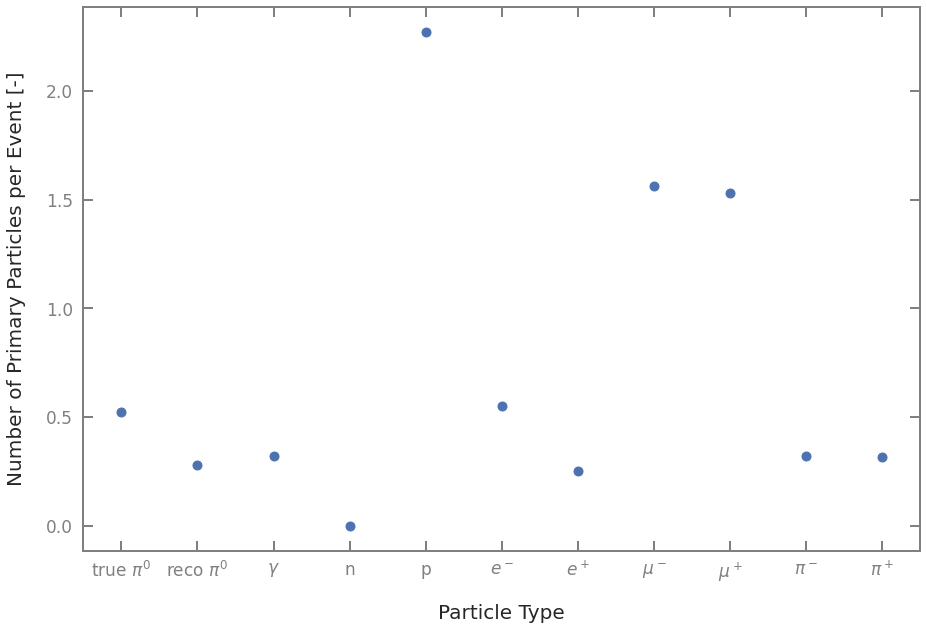

In [10]:
import pandas as pd
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = -0.5
x_max    = 5.5
n_bins_x = 6
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'


labels = ['true $\pi^0$','reco $\pi^0$','$\gamma$','n','p','$e^-$','$e^+$','$\mu^-$','$\mu^+$','$\pi^-$','$\pi^+$']
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
#plt.xlabel('Labels', fontsize=10, labelpad=10)


data_list = 1./data_size * np.array([n_true_pi0,\
                                     n_reco_pi0,\
                                     n_primary_photons,\
                                     n_primary_n,\
                                     n_primary_p,\
                                     n_primary_e_minus,\
                                     n_primary_e_plus,\
                                     n_primary_mu_minus,\
                                     n_primary_mu_plus,\
                                     n_primary_pi_minus,\
                                     n_primary_pi_plus])
print(data_list)
x_vals = [i for i in range(len(data_list))]

# Plot n_edeps
n, bins, patches = plt.errorbar(x_vals, data_list, xerr=None, yerr=None, fmt='o')

# Legend
#plt.legend(loc=[0.85,0.85], prop={'size': 17}) # loc='upper right'

# Axis labels
plt.xlabel('Particle Type', fontsize=20, labelpad=20)
plt.ylabel('Number of Primary Particles per Event [-]', fontsize=20, labelpad=20)

#plt.ylim(bottom=0, top=200)
#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)
#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')

# Save figure
fig_name = 'PrimaryParticles_in_file_pi0_dunend_v1_p00.png'
#fig_name = 'pi0_mass_02_' +\
#            str(data_size) + 'ev_' +\
#            'refit_dir_' + str(chain.cfg['refit_dir']) + '_' +\
#            'fiducial_0px_' +\
#            'no_selection_cut.png'
#if make_plots:
plt.savefig(fig_name, dpi=400) # bbox_inches='tight'

In [11]:
print(' Number of events with == 0 true pi0: ', len([i for i in n_true_pi0_list if i==0]), ' \t (', len([i for i in n_true_pi0_list if i==0])/len(n_true_pi0_list)*100, '% )')
print(' Number of events with == 1 true pi0: ', len([i for i in n_true_pi0_list if i==1]), ' \t (', len([i for i in n_true_pi0_list if i==1])/len(n_true_pi0_list)*100, '% )')
print(' Number of events with == 2 true pi0: ', len([i for i in n_true_pi0_list if i==2]), ' \t (', len([i for i in n_true_pi0_list if i==2])/len(n_true_pi0_list)*100, '% )')

 Number of events with == 0 true pi0:  994  	 ( 49.7 % )
 Number of events with == 1 true pi0:  972  	 ( 48.6 % )
 Number of events with == 2 true pi0:  32  	 ( 1.6 % )


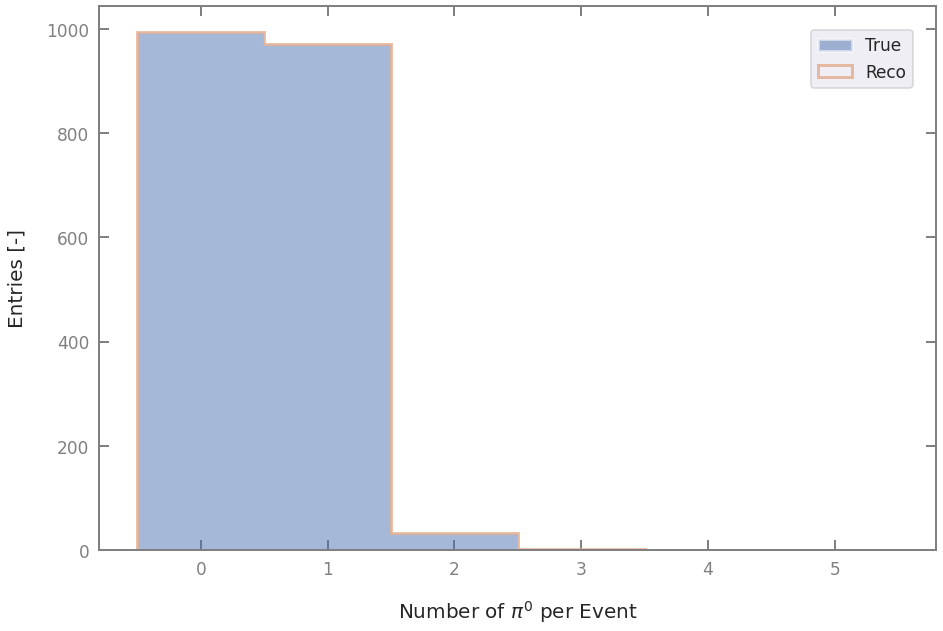

In [12]:
import pandas as pd
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = -0.5
x_max    = 5.5
n_bins_x = 6
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'

# Plot n_edeps
n0, bins0, patches0 = plt.hist(n_true_pi0_list, label='True', bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', stacked=False, linewidth=3, alpha=0.5)
n1, bins1, patches1 = plt.hist(n_reco_pi0_list, label='Reco', bins=n_bins_x, range=[x_min,x_max], histtype='step',       stacked=False, linewidth=3, alpha=0.5)

# Legend
plt.legend(loc=[0.85,0.85], prop={'size': 17}) # loc='upper right'

#plt.xlim(0,10)
#plt.ylim(-2, 200)

# Axis labels
plt.xlabel('Number of $\pi^0$ per Event', fontsize=20, labelpad=20)
plt.ylabel('Entries [-]', fontsize=20, labelpad=20)

#plt.ylim(bottom=0, top=200)
#plt.yscale('log') # linear, log
#plt.yscale('symlog', linthreshy=1)
#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2, label='Literature value for $\pi^0$ mass')

# Save figure
fig_name = 'N_pi0_in_file_pi0_dunend_v1_p00.png'
#fig_name = 'pi0_mass_02_' +\
#            str(data_size) + 'ev_' +\
#            'refit_dir_' + str(chain.cfg['refit_dir']) + '_' +\
#            'fiducial_0px_' +\
#            'no_selection_cut.png'
#if make_plots:
plt.savefig(fig_name, dpi=400) # bbox_inches='tight'